<a href="https://colab.research.google.com/github/AxelBadouel/machinelearningcourse/blob/main/FL_personal_data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load libraries here

In [1]:
%matplotlib inline

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import random
import numpy as np
import copy
from tempfile import TemporaryDirectory
from sklearn.metrics import accuracy_score
from google.colab import drive
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings
warnings.filterwarnings("ignore")

random.seed(42)
torch.manual_seed(42)

# Data preprocessing

Data exploration.

The train_data and test_data declared here are going to be used in the creation of the dataset and therefore dataloader of the client.

In [2]:
# Maybe normalize the data later on in case the accuracy needs improvement.
# If I do it here, I don't know how performing a normalization here will influence the visualization.
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.CIFAR100(
    root='data',
    train=True,
    download=True,
    transform=data_transform
)

test_data = datasets.CIFAR100(
    root='data',
    train=False,
    download=True,
    transform=data_transform
)

100%|██████████| 169M/169M [00:02<00:00, 60.4MB/s]


train_data and test_data are 2 lists of tuples. <br> For instance, train_data[0] is a tuple with train_data[0][0] being an image.

In [ ]:
tensor = train_data[0][0]
print(tensor.size())

torch.Size([3, 32, 32])


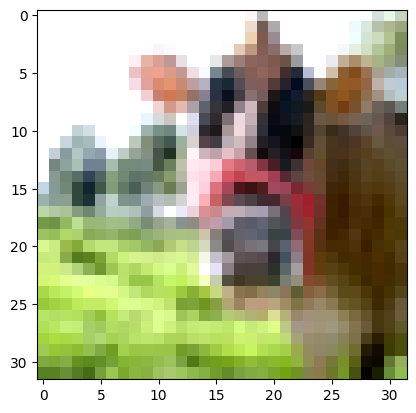

In [ ]:
mean = torch.tensor([0.5071, 0.4865, 0.4409])
std = torch.tensor([0.2673, 0.2564, 0.2762])

unnormalized_tensor = tensor * std[:, None, None] + mean[:, None, None]
unnormalized_tensor =unnormalized_tensor.permute(1, 2, 0)
plt.imshow(unnormalized_tensor)
plt.show()

In [ ]:
# Unnormalization function for visualization of the images
def unnormalize(image_tensor):
  mean = torch.tensor([0.5071, 0.4865, 0.4409])
  std = torch.tensor([0.2673, 0.2564, 0.2762])

  unnormalized_tensor = image_tensor * std[:, None, None] + mean[:, None, None]
  unnormalized_tensor = unnormalized_tensor.permute(1, 2, 0)
  return unnormalized_tensor

In [ ]:
#What is the type of the datasets and the type of each element?
print(f"train data: {train_data}\ntrain data type: {type(train_data)}")
print(f"train data type: {type(train_data[0])} with length: {len(train_data[0])}\ntrain_data[0][0]: {type(train_data[0][0])}\ntrain_data[0][1]: {type(train_data[0][1])}\n")

print(f"test data: {test_data}\ntest data type: {type(test_data)}")
print(f"test data type: {type(test_data[0])} with lenght: {len(test_data[0])}\ntest_data[0][0]: {type(test_data[0][0])}\ntest_data[0][1]: {type(test_data[0][1])}")

train data: Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
train data type: <class 'torchvision.datasets.cifar.CIFAR100'>
train data type: <class 'tuple'> with length: 2
train_data[0][0]: <class 'torch.Tensor'>
train_data[0][1]: <class 'int'>

test data: Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
test data type: <class 'torchvision.datasets.cifar.CIFAR100'>
test data type: <class 'tuple'> with lenght: 2
test_data[0][0]: <class 'torch.Tensor'>
test_data[0][1]: <class 'int'>


In [ ]:
print(type(test_data[0][1]))

<class 'int'>


Experiment: Not relevant to the training test we're trying to perform.

In [ ]:
# Shape
image, label = train_data[0]
print(f"image label: {label}\nimage shape: {image.shape}")

image label: 19
image shape: torch.Size([3, 32, 32])


Experiment: Not relevant to the training test we're trying to perform.

In [ ]:
# Classes available
classes = train_data.classes
print(classes)
print(f"classes length: {len(classes)}\nclass at position label: {classes[label]}")

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

Visualizing images

Experiment: Not relevant to the training test we're trying to perform.

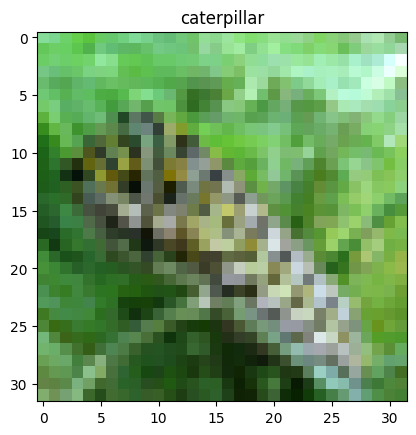

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

index = 89     #@param{min:0, max:50000}

image, label = train_data[index]
image_np = image.permute(1, 2, 0)

plt.imshow(unnormalize(image))
plt.title(classes[label])
plt.show()

Plotting a few more images.

Experiment: Not relevant to the training test we're trying to perform.

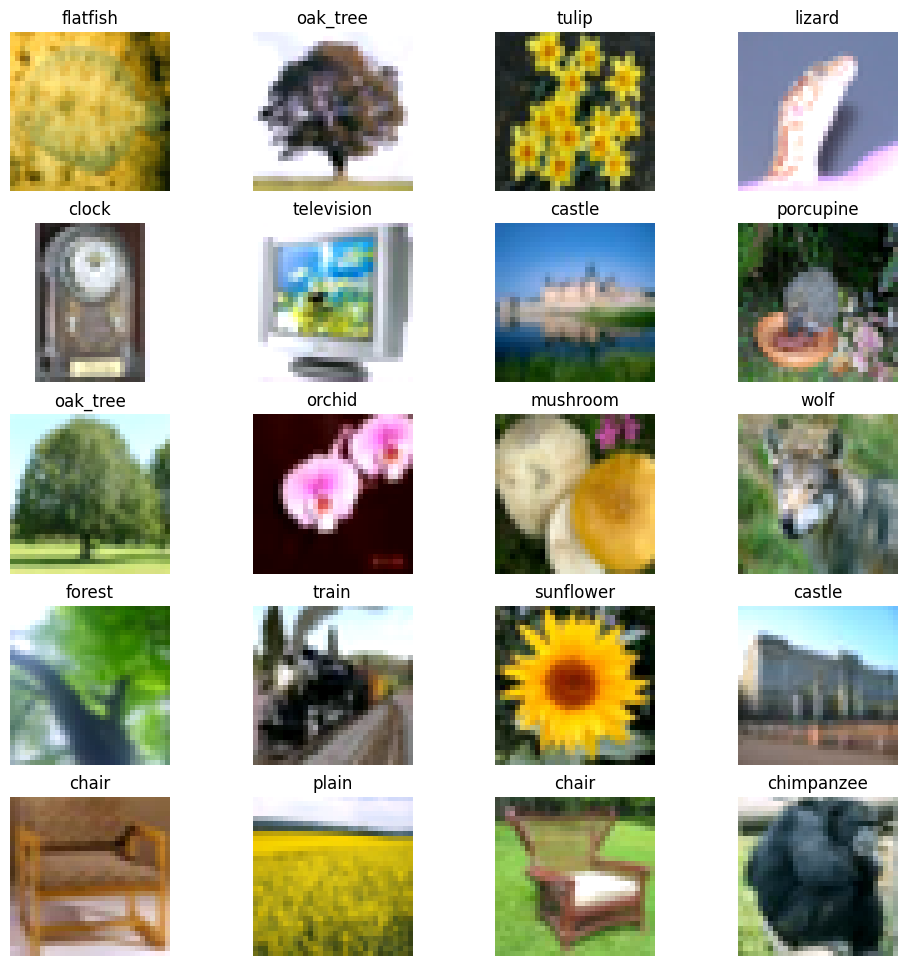

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    #torch.randint generates a random tensor between (optional) low = 0 and higher = len(train_data) of dimension size = 1[if size = (2,2) then 2x2 matrix etc]
    img_idx = torch.randint(len(train_data), size=[1]).item()
    img, label = train_data[img_idx]
    fig.add_subplot(rows, columns, i)
    plt.imshow(unnormalize(img))
    plt.title(classes[label])
    plt.axis('off')

# Objects Useful for Training and Testing

Let's add google drive to save and load models' parameters

In [3]:
# 1. Mount Drive
drive.mount('/content/drive')

# 2. Base directory for all models. If not existing, create it
BASE_PATH = '/content/drive/My Drive/Federated_learning_models'

CENTRALIZED = 'centralized'
FEDERATED_IID = 'federated_idd'
FEDERATED_NON_IID = 'federated_non_idd'
CENTRALIZED_MODEL_EDITING = 'centralized_model_editing'
FEDERATED_IID_MODEL_EDITING = 'federated_iid_model_editing'
FEDERATED_NON_IID_MODEL_EDITING  = 'federated_non_iid_model_editing'


if not os.path.exists(BASE_PATH):
  os.makedirs(BASE_PATH)
  print(f"Created directory: {BASE_PATH}")
else:
  print(f"Directory already exists: {BASE_PATH}")

Mounted at /content/drive
Created directory: /content/drive/My Drive/Federated_learning_models


In [4]:
def save_model(model, model_name, epoch_round, optimizer, training_loss, validation_loss):
    """
    Saves a model to Google Drive with other parameters.

    Args:
        model: The model object (model.state_dict())
        model_name: String, unique identifier (e.g., 'CNN_Variation_1')
        epoch_round: current epoch. Training of baseline model: epoch. Training of central model: round
        optimizer: to save the optimizer parameters
        training_loss: To save the current training loss
        validation_loss: Holds  current validation loss
    """
    filename = f"{model_name}.pth"
    save_path = os.path.join(BASE_PATH, filename)

    # 4. Prepare the checkpoint
    checkpoint = {
        'model_state': model.state_dict(),
        'epoch_round': epoch_round,
        'optimizer_state': optimizer.state_dict(),
        'training_loss': training_loss.item(),
        'validation_loss': validation_loss.item(),
    }

    # 5. Save
    torch.save(checkpoint, save_path)
    print(f"Model saved to: {save_path}")
    #return save_path

In [5]:
def load_model(model, model_name, optimizer):
  """
    Loads model from Google Drive with other parameters.

    Args:
        model: The model object (model.state_dict())
        model_name: String, unique identifier (e.g., 'CNN_Variation_1')
        epoch_round: current epoch. Training of baseline model: epoch. Training of central model: round
        optimizer: Holds optimizer parameters
        training_loss: Holds  current training loss
        validation_loss: Holds  current validation loss
    """
  file_name = {model_name} + ".pth"
  model_path = os.path.join(BASE_PATH, file_name)

  if not os.path.exists(model_path):
    print("No checkpoint found. Starting the traiing at epoch 0.")
    return model, optimizer, 0, 0, 0

  print(f"Checkpoint found at {model_path}. Loading...")
  checkpoint = torch.load(model_path)

  model.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optimizer_state'])
  epoch_round = checkpoint['epoch_round']
  training_loss = checkpoint['training_loss']
  validation_loss = checkpoint['validation_loss']

  print(f"Resuming from Epoch {epoch_round}. Prevous Loss: {training_loss:.4f}")

  return model, optimizer, epoch_round, training_loss, validation_loss

In [6]:
# Let's see if the training and test pictures have the same classes
train_classes = set(train_data.classes)
test_classes = set(test_data.classes)

print(train_classes == test_classes)

True


Here is a class to turn the data list of data into a dataset before creating the data loaders.

In [7]:
class CustomDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    image_tensor, label = self.data[idx]
    return image_tensor, label

Now that we have the training and test datasets for each class, let's build a function to generate the dataloaders for each one of them.

In [14]:
def dataloaderMaker(dataset):
  """
    This function takes in the datasets created earlier in the forms of lists of tuples,
    and returns 2 dataloaders for the training and testing of the client models.
  """
  BATCH_SIZE = 32

  dataloader = DataLoader(
      dataset=CustomDataset(dataset),
      batch_size=BATCH_SIZE,
      shuffle=True
  )

  return dataloader

In order to optimize the operation of model editing, we use a method to create an object with the same architecture as the Dino NN but without performing any deep copy for each client.

In [ ]:
def get_dino_architecture():
  """
  Initializes the DINO-ViT architecture (ViT-S/16) adapted for 32x32 images.

  This function must be defined gllobally so
  """

# Training Without Model Editing

Training function. <br> This function implements full fine tuning(FT) as all the parameters of te pretrained NN are being fine-tuned and the new head is being trained. It would be good to look into linear probing(LP), that is, training of the new head only. According to Ananya Kumar et .al in the paper "Fine-Tuning can Distort Pretrained Features and Underperform Out-of-Distribution", it is better to combine both: perform Linear probing first, then fine-tune. <br> In-Distribution: Real life data/ test data that come from the same domain as the model has been trained on. <br>
Out-of-Distribution: Real life data/ test data that come from a different domain from the one the model has been trained on. <br>
For ID data, FT > LP<br>
For OOD data, LP > FT<br>
For ID+OOD data, LP-FT > FT and LP

In [9]:
def train_model(model, model_name, train_dataloader, val_dataloader, client_train_data, client_validation_data, device, min_delta=0.1, patience=3):
  # ----- A. INITIALIZATION -----
  start_time = time.time()

  num_epochs = 100
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(dino_vits16.parameters(), lr=0.001, momentum=0.9)   # Momentum, SGD becomes SGDM

  scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

  train_losses = []
  val_losses = []

  best_val_loss = float('inf')
  trigger_times = 0  # how many epochs since last improvement
  best_model_state = None
  start_epoch = 0

  # ----- B. RESUME CHECH -----
  model, optimizer, start_epoch, train_loss, val_loss = load_model(model, model_name, optimizer)

  # ----- C.TRAINING LOOP -----
  for epoch in range(start_epoch, num_epochs):
    if trigger_times < patience:
      model.train()  # Set model to training mode

      for inputs, labels in train_dataloader:
          inputs, labels = inputs.to(device), labels.to(device) # move the batch to the device

          optimizer.zero_grad() # Clear the previous gradients
          outputs = model(inputs)    # Forward pass
          loss = criterion(outputs, labels)   # Compute losses
          loss.backward()    # Backpropagation
          optimizer.step()    # Update model parameters
          train_loss += loss.item() * inputs.size(0)

      train_loss /= len(client_train_data)
      train_losses.append(train_loss)     # Save training loss
      scheduler.step()

    # Compute Validation loss during training
    model.eval()    # Set model to evaluation mode
    with torch.no_grad():     # Disable gradient computation for validation
      for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        val_outputs = model(inputs)
        loss = criterion(val_outputs, labels)
        val_loss += loss.item() * inputs.size(0)
      val_loss /= len(client_validation_data)     # Compute validation loss
      val_losses.append(val_loss)

    if (epoch + 1 ) % 10 == 0:
      print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
      save_model(model, model_name, epoch, optimizer, train_losses[-1], val_losses[-1])   # Save the current model in case of disconnection from Collab

    # ---- Early Stopping ----
    if (min_delta != None):
      if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_train_loss = train_loss
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        trigger_times = 0
    else:
      trigger_times += 1

  if trigger_times >= patience:
      print(f"Early stopping at epoch {epoch + 1} (best val loss: {best_val_loss:.6f})")

  # ---- Restore best model ----
  if best_model_state is not None:
    model.load_state_dict(best_model_state)
    save_model(model, model_name, epoch, optimizer, best_train_loss, best_val_loss)  # Overwrite the existing file and have it save the best model

  # Record the end time
  end_time = time.time()
  # Calculate the elapsed time
  elapsed_time = end_time - start_time
  print(f'The function took {elapsed_time:.4f} seconds to execute.')

  # Plot the training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

  return

Code for evaluation

In [10]:
def evaluation_model(model, dataloader):
    start_time = time.time()

    criterion = nn.CrossEntropyLoss()

    model.eval()   # Set model to evaluate mode

    all_labels = []
    all_predictions = []

    with torch.no_grad(): # Disable gradient calculation during evaluation
      for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, prediction = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(prediction.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f"The function tok {elapsed_time:.4f} seconds to execute.")

    return accuracy

 Visualizing the model's predictions


Loading of the model for the client for training on the dataset with fine tuning of the whole model.

# Dino model loading

In [6]:
# Importing pretrained DINO Vision Transformer as Global model
dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Using cpu device


# Training and Teasting of baseline model

1.   Training validation dataset spliting
2.   Creation of the dataloaders
3.   Training of baseline
4.   Validation of baseline

In [ ]:
baseline_train_data, baseline_val_data = random_split(train_data, [0.8, 0.2])

In [ ]:
baseline_train_dataloader = dataloaderMaker(baseline_train_data)
baseline_val_dataloader = dataloaderMaker(baseline_val_data)
baseline_test_dataloader = dataloaderMaker(test_data)

In [ ]:
baseline_model = copy.deepcopy(dino_vits16)
baseline_model = baseline_model.to(device)
model_head = len(train_data.classes)

# Because the baseline model has to train and be able to classify elements from the whole dataset
# In the IID case, the clients train on the whole dataset and so, the Linear head should be the same as the number of classes
baseline_model.head = nn.Linear(dino_vits16.embed_dim, model_head)

model_name = "baseline_model"

KeyboardInterrupt: 

In [ ]:
train_model(baseline_model, baseline_train_dataloader, baseline_val_dataloader, baseline_train_data, baseline_val_data, device, min_delta=0.05, patience=3)  # Baseline training

In [ ]:
evaluation_model(baseline_model, baseline_test_dataloader)    # Baseline validation

# Usefull functions for the training

Now we have completed the model baseline model for the benchmark, we pass to the Federated learning scenario with iid dataset.

We first initialize some basic parameters and then create subsets of data of Identical and Independent Distribution with the corresponding dataloaders.

In [ ]:
def iid_dataloaders_spliting(train_data, number_clients = 100):

  client_train_data = []
  client_validation_data = []

  #------TRAINING DATA------------
  # Splitting training and validation data
  iid_train_data = copy.deepcopy(train_data)
  random.shuffle(iid_train_data)
  split_idx = len(iid_train_data)*0.8
  client_train_data = iid_train_data[split_idx:]
  client_validation_data = iid_train_data[:split_idx]

  # Division of the training data into 100 sub datasets with the same number of elements with the corresponding datasets
  N_train = len(client_train_data)
  subtraindataset_size = N_train // number_clients
  indices = torch.randperm(N_train).tolist()  # Random shuffle for IID splits

  #------VALIDATION DATA------------
  # Division of the training data into 100 sub datasets with the same number of elements with the corresponding datasets
  N_val = len(client_validation_data)
  subvaldataset_size = N_val // number_clients
  indices = torch.randperm(N_val).tolist()  # Random shuffle for IID splits

  subdatasets = []      # List of dictionaries of train and validation datasets for each client
  for i in range(number_clients):
    client_data = {}
    start_id_current_subtraindataset = i * subtraindataset_size
    end_id_current_subtraindataset = start_id_current_subtraindataset + subtraindataset_size
    subset_indices = indices[start_id_current_subtraindataset:end_id_current_subtraindataset]   # Take all the indices in the defined range
    client_data['Training'] = [client_train_data[k] for k in indices]

    start_id_current_subvaldataset = i * subvaldataset_size
    end_id_current_subvaldataset = start_id_current_subvaldataset + subvaldataset_size
    subset_indices = indices[start_id_current_subvaldataset:end_id_current_subvaldataset]   # Take all the indices in the defined range
    client_data['Validation'] = [client_train_data[k] for k in indices]

    subdatasets.append(client_data)

  subdataloaders = []     # List of dictionaries of dataloaders for training and validation
  for client_data in subdatasets:
    client_loader = {}
    client_loader['Training'] = dataloaderMaker(client_data['Training'])
    client_loader['Validation'] = dataloaderMaker(client_data['Validation'])
    client_loader['Train_data_len'] = len(client_data['Training'])

    subdataloaders.append(client_loader)

  return subdataloaders

This function creates the dataloaders for the non iid case

In [ ]:
def non_iid_client_dataloaders(train_data, classes_per_client, number_of_clients):
  labels = train_data.targets
  random.shuffle(labels)
  labels_per_client = []

  # Divide the labels for each client
  for i in range(number_of_clients):
    labels_current_client = labels[i : i + classes_per_client]
    labels_per_client.append(labels_current_client)

  clients_datasets = []     # List containing the lists of datasets
  for client in range(len(labels_per_client)):
    labels_current_client = labels_per_client[client]
    current_client_dataset = []
    for data in train_data:
      if data[1] in labels_current_client:
        current_client_dataset.append(data)
    clients_datasets.append(current_client_dataset)

  clients_split_datasets = []
  for client_data in clients_datasets:
    client_split = {}
    random.shuffle(client_data)
    split_idx = len(client_data)*0.8
    client_train_data = client_data[split_idx:]
    client_validation_data = client_data[:split_idx]
    client_split['Training'] = client_train_data
    client_split['Validation'] = client_validation_data

    clients_split_datasets.append(client_split)

  clients_dataloaders = []

  for client_split in clients_split_datasets:
    client_loader = {}
    client_loader['Training'] = dataloaderMaker(client_split['Training'])
    client_loader['Validation'] = dataloaderMaker(client_split['Validation'])
    client_loader['Train_data_len'] = len(client_train_data)

    clients_dataloaders.append(client_loader)

  return clients_dataloaders

Now that we have our list of dataloaders, we can write the method for the clients and the server. This will be done following McMahan et al.:

In [ ]:
DinoModelClass = type(dino_vits16)

def modelClass(num_classes = None):
  model = copy.deepcopy(dino_vits16)    # Deep copy so as not to modify dino in case we need it later
  if num_classes:
    model_head = num_classes
  else:
    model_head = len(train_data.classes)

  model.head = nn.linear(model.embed_dim, model_head)

  return type(model)

In [ ]:
# We then define a method that will handle model training in each function
def client_update(len_of_client_data, global_weights, dataloader, optimizer, criterion, num_classes, local_steps = 4):
  """
  Receives weights and trains on them and then returns updated state_dict.

  """

  # A copy of the model architecture is used by the client
  client_model = modelClass(num_classes)

  # Copy of the weights to configure the model for current learning
  client_model.load_state_dict(global_weights)

  # Dataloader for this client
  train_dataloader = dataloader

  num_epochs = local_steps
  train_losses = []

  # ----- TRAINING LOOP -----
  for epoch in range(num_epochs):
      client_model.train()  # Set model to training mode

      for inputs, labels in train_dataloader:
          inputs, labels = inputs.to(device), labels.to(device) # move the batch to the device

          optimizer.zero_grad() # Clear the previous gradients
          outputs = client_model(inputs)    # Forward pass
          loss = criterion(outputs, labels)   # Compute losses
          loss.backward()    # Backpropagation
          optimizer.step()    # Update model parameters
          train_loss += loss.item() * inputs.size(0)

      train_loss /= len_of_client_data
      train_losses.append(train_loss)

  model_weight_update = client_model.state_dict()

  return model_weight_update, train_losses

For the training of the global model, we could go with 25 rounds because if the base model is trained with 100 epochs then 25 rounds x 4 epochs per client = 100. This is for now. Later on we will see how it goes.

In [ ]:
def federated_simulation_server(local_steps = 4, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=3, iid_datasets = True, classes_per_client = None):
  if fraction_of_clients > 1:
    return

  list_of_clients = [i for i  in range(number_of_clients)]

  ModelClass = modelClass(classes_per_client)
  global_model = ModelClass()

  if iid_datasets:   # To save the models under files with different names
    model_name = "global_model_iid"
  else:
    model_name = "global_model" + str(classes_per_client)

  global_model_weights = dino_vits16.state_dict()

  start_time = time.time()

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(dino_vits16.parameters(), lr=0.001, momentum=0.9)   # Momentum, SGD becomes SGDM

  scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_rounds, eta_min=1e-6)

  train_losses = []
  val_losses = []

  best_val_loss = float('inf')
  trigger_times = 0  # how many rounds since last improvement
  best_model_state = None
  start_round = 0

  # ----- B. RESUME CHECK IF TRAINING WAS INTERUPTED -----
  model, optimizer, start_round, train_loss, val_loss = load_model(model, model_name, epoch_round, optimizer, training_loss, validation_loss)


  #------TRAINING ROUNDS START HERE---------------------
  for rnd in range(start_round, total_rounds):
    if trigger_times < patience:
      m = fraction_of_clients * len(list_of_clients)
      S = random.sample(list_of_clients, m)

      if iid_datasets:
        dataloaders = iid_dataloaders_spliting(train_data, number_of_clients)
      else:
        # If in the non iid case
        if classes_per_client == None:
          classes_per_client = 5
        dataloaders = non_iid_dataloaders_spliting(train_data, classes_per_client, number_of_clients)

      model_weights = []
      for client in S:
        weights, losses = client_update(local_steps = 4, dataloaders[client]['Train_data_len'], global_model_weights, dataloaders[client]['Training'], optimizer, criterion, classes_per_client)
        model_weights.append(weights)

    scheduler.step()
    # Because all the classes have the same length, there is no need for a weighted average based on that
    # so I skipped the part of McMahan related to that and do not include it in the final averaging
    global_model_weights = pd.DataFrame(model_weights).mean().to_dict()

    global_model.load_state_dict(global_model_weights)
    # Compute Validation loss during training
    model.eval()    # Set model to evaluation mode
    val_dataloader = valdataloaders[client]
    with torch.no_grad():     # Disable gradient computation for validation
      for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        val_outputs = model(inputs)
        loss = criterion(val_outputs, labels)
        val_loss += loss.item() * inputs.size(0)
      val_loss /= len(client_validation_data)     # Compute validation loss
      val_losses.append(val_loss)

    if (rnd + 1 ) % 2 == 0: # Since there are generally not many rounds, I save every 2 rounds rounds
      print(f"Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_losses[-1]:.4f}")
      save_model(model, model_name, epoch, optimizer, None, val_losses[-1])   # Save the current model in case of disconnection from Collab

    # ---- Early Stopping ----
    if (min_delta != None):
      if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_train_loss = None
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        trigger_times = 0
    else:
      trigger_times += 1

  if trigger_times >= patience:
      print(f"Early stopping at epoch {epoch + 1} (best val loss: {best_val_loss:.6f})")

  # ---- Restore best model ----
  if best_model_state is not None:
    model.load_state_dict(best_model_state)
    save_model(model, model_name, epoch, optimizer, best_train_loss, best_val_loss)  # Overwrite the existing file and have it save the best model

  # Record the end time
  end_time = time.time()
  # Calculate the elapsed time
  elapsed_time = end_time - start_time
  print(f'The function took {elapsed_time:.4f} seconds to execute.')

  # Plot the validation loss ignoring the training losses as each has its own training loss and there would be too many graphs to handle for each round
  plt.figure(figsize=(10,5))
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Validation Loss')
  plt.legend()
  plt.show()

  return


# We launch federated learning on iid datasets:

In [ ]:
num_classes = len(train_data.classes)
federated_simulation_server(local_steps = 4, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = True, classes_per_client = None)

# We launch federated learning on Non IID Datasets

Output for 1 class per client and 4 local steps:

In [ ]:
federated_simulation_server(local_steps = 4, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 1)

Output for 1 class per client and 8 local steps:

In [ ]:
federated_simulation_server(local_steps = 8, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 1)

Output for 1 class per client and 16 local steps:

In [ ]:
federated_simulation_server(local_steps = 16, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 1)

Output for 5 classes per client and 4 local steps:

In [ ]:
federated_simulation_server(local_steps = 4, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 5)

Output for 5 classes per client and 8 local steps:

In [ ]:
federated_simulation_server(local_steps = 8, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 5)

Output for 5 classes per client and 16 local steps:

In [ ]:
federated_simulation_server(local_steps = 16, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 5)

Output for 10 classes per client and 4 local steps:

In [ ]:
federated_simulation_server(local_steps = 4, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 10)

Output for 10 classes per client and 8 local steps:

In [ ]:
federated_simulation_server(local_steps = 8, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 10)

Output for 10 classes per client and 16 local steps:

In [ ]:
federated_simulation_server(local_steps = 16, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 10)

Output for 50 classes per client and 4 local steps:

In [ ]:
federated_simulation_server(local_steps = 4, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 50)

Output for 50 classes per client and 8 local steps:

In [ ]:
federated_simulation_server(local_steps = 8, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 50)

Output for 50 classes per client and 16 local steps:

In [ ]:
federated_simulation_server(local_steps = 16, number_of_clients = 100, fraction_of_clients = 0.1, total_rounds = 25, min_delta=0.1, patience=10, iid_datasets = False, classes_per_client = 50)

Is there a noticeable difference in performance? Motivate your findings:

See slide 33 of MLME-L19-Federated.pdf
It explains that although the use of momentum in Federated learning allows for convergence under full participation in a heterogenous dataset setting, this is not the case when it comes to partial participation as is the case here.